In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torchvision
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms

### MLP on Large Data set with PyTorch

Let's create a NN on a bigger data set. We will use MNIST Digit set. This time we will upload a set containing 60000 digits of oh higher quality than before. We will use PyTorch to do so. We will also preprocess our data. We will use `transforms`, which is a way to create Pipelines with PyTorch. I want to convert every image into Tensor and then Normalize the values so that they are smaller. We can apply these transforms directly the moment we upload our data sets.



In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),    # mean and std
                              ])

In [3]:
trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Let's look at the single batch.

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)


print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


As you can see, a single batch is a 4-dim array:
1. 64 is the amount of images in the single batch
2. 1 is a color channel. Since our images are greyscale we have only one chanel. This dim is useless to us. Technically, we could have applied transform to get rid of it. Note, if our image is a color image, this will usually have 3 values (RGB).
3. 28, 28 is the size of a single image. It is 28 by 28 pixels.

Let's see what a the first inmage looks like. (`squeeze` gets rid of singular dimension)

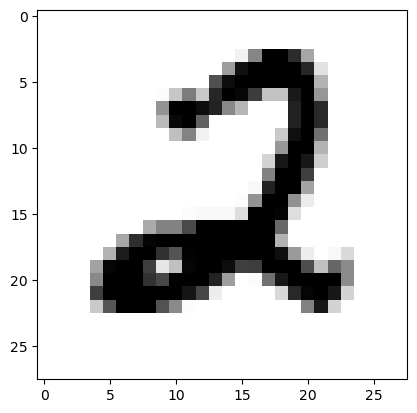

In [7]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

And here are few more examples:

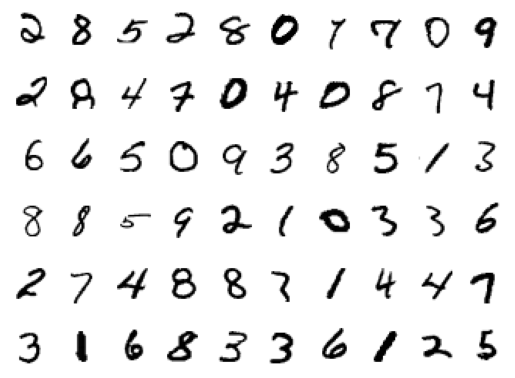

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Before we start creating our models, I want to add a small function to calculate accuracy and loss:

In [9]:
def get_acc_loss(model, loader):
    correct=0
    total=0
    for images, labels in loader:
        images = images.reshape(-1, 28*28)
        output=model(images)
        pred = output.data.max(1, keepdim=True)[1]
        total+=labels.shape[0]
        correct += pred.eq(labels.data.view_as(pred)).sum()
        loss=loss_func(output, labels)
    acc=100.*correct/total
    return acc, loss

Let's create our NN. This time I will use 2 hidden layers. I will also add `nn.Sequential` to avoid retyping our functions in the forward method. Lastly, I will use `flatten` to convert 28 by 28 array into a single dimension vector of size 28*28 = 784

In [10]:
input_size = 784     # 28*28
hidden_sizes = [128, 64] #two hidden layers
output_size = 10


class DigitMLP(nn.Module):
    
    def __init__(self):
        super(DigitMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



In [11]:
model = DigitMLP()
print(model)

n_epochs=3
lr=0.01

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum =0.9)


DigitMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


Instead of using CrossEntropyLoss we could have used NLLLoss, but then we would have to add Softmax as last activation function

In [12]:
train_loss = []
test_loss = []

train_acc=[]
test_acc=[]

In [13]:
n=len(trainloader)

for epoch in range(n_epochs):
    model.train()
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        images = images.reshape(-1, 28*28)
        output = model(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()

        if (idx+1)%100==0:
            print(f'Epoch {epoch+1}/{n_epochs}, step {idx+1}/{n}, Loss={loss.item():.3}')

    model.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model, testloader)            
        test_acc.append(acc)
        test_loss.append(loss)
        print(f'\nTest Accuracy = {acc}, Test Loss = {loss} \n')

        acc, loss = get_acc_loss(model, trainloader)            
        train_acc.append(acc)
        train_loss.append(loss)

Epoch 1/3, step 100/938, Loss=0.532
Epoch 1/3, step 200/938, Loss=0.565
Epoch 1/3, step 300/938, Loss=0.33
Epoch 1/3, step 400/938, Loss=0.189
Epoch 1/3, step 500/938, Loss=0.259
Epoch 1/3, step 600/938, Loss=0.309
Epoch 1/3, step 700/938, Loss=0.262
Epoch 1/3, step 800/938, Loss=0.367
Epoch 1/3, step 900/938, Loss=0.143

Test Accuracy = 93.69000244140625, Test Loss = 0.023973999544978142 

Epoch 2/3, step 100/938, Loss=0.13
Epoch 2/3, step 200/938, Loss=0.131
Epoch 2/3, step 300/938, Loss=0.273
Epoch 2/3, step 400/938, Loss=0.266
Epoch 2/3, step 500/938, Loss=0.188
Epoch 2/3, step 600/938, Loss=0.124
Epoch 2/3, step 700/938, Loss=0.0617
Epoch 2/3, step 800/938, Loss=0.121
Epoch 2/3, step 900/938, Loss=0.0608

Test Accuracy = 96.08999633789062, Test Loss = 0.03308149054646492 

Epoch 3/3, step 100/938, Loss=0.143
Epoch 3/3, step 200/938, Loss=0.0966
Epoch 3/3, step 300/938, Loss=0.0713
Epoch 3/3, step 400/938, Loss=0.0507
Epoch 3/3, step 500/938, Loss=0.489
Epoch 3/3, step 600/938, Los

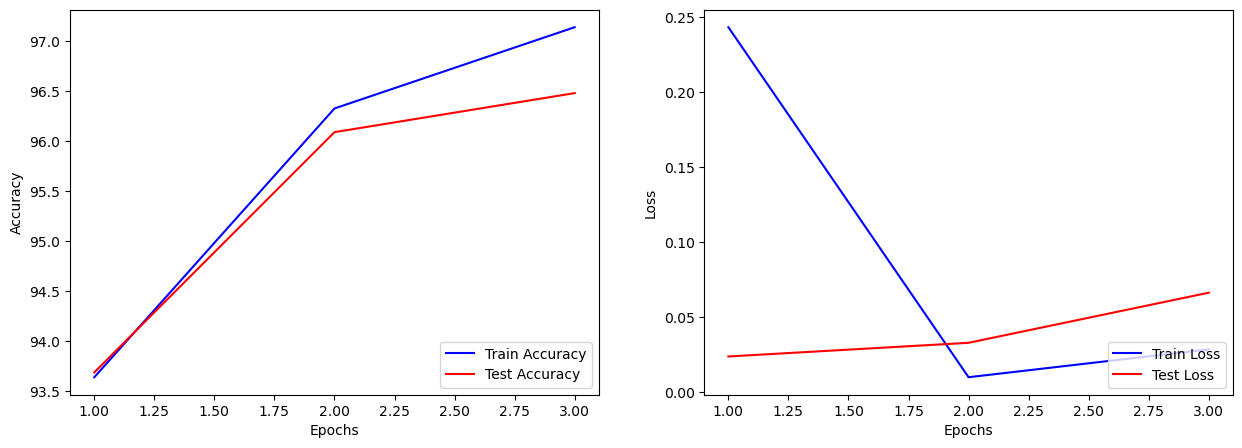

In [14]:
fig, ax= plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,n_epochs+1, 1), train_acc, color='blue')
ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc, color='red')
ax[0].legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(np.arange(1,n_epochs+1, 1), train_loss, color='blue')
ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss, color='red')
ax[1].legend(['Train Loss', 'Test Loss'], loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [15]:
predictions = []
y_true = []

# iterate over test data
for inputs, labels in testloader:

        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1])
        predictions.extend(output) # Save Prediction
        
        labels = labels.data.numpy()
        y_true.extend(labels) # Save Truth


print('Confusion Matrix = \n',confusion_matrix(y_true, predictions))

Confusion Matrix = 
 [[ 955    0    2    0    0    6   12    2    2    1]
 [   0 1125    2    1    0    1    3    1    2    0]
 [   7    8  994    2    3    0    4    6    8    0]
 [   0    3   11  959    0   14    2   11    9    1]
 [   0    1    7    0  951    1    5    4    2   11]
 [   3    1    0    5    2  862   11    0    5    3]
 [   3    3    0    0    5    2  942    0    3    0]
 [   2   15    9    3    2    1    0  985    1   10]
 [   2    3    3    8    5    3    6    3  940    1]
 [   3    9    0    5   29   11    1    8    8  935]]


### How do we choose amount of layers and amount of nodes in each layer?

For input and output layer the this is easy, there is only one choice. However for hidden layers this is not an easy question and highly depends on many factors. Clearly, the more layers and more nodes we have the more computationally expensive model will be. Another thing to keep in mind is that the more layers we have, more likely we will get Vanishing Gradient Problem. So, for very deep networks, we should apply more spcialized algorithms. However, for most problems we don't need very deep networks:

1. If your data is linearly separable, then you actually dont need any hidden layers. You dont really need NN at all here.
2. A single hidden layer can solve most problems.
3. Problems that require two hidden layers are more rare, but we can create almost any desision boundary with it.
4. Generally, the more features you have, the more layers you will probably want. Hidden layers in deep NN are generally more complex than just a linear layers we discussed so far. Problems that often use deep NN:
       a. Image or video recognision problems will use deeper NN (CNN);
       b. Language processing (translation, text generation, etc) will use deep NN (RNN, Transformers)
       c. Time series forecasting often use deed NN (LSTM)
       d. Speech Recognition use deep CNN and/or RNN.
5. Adding more layers may lead to overfit, so more is not always better.

How about number of nodes in each hidden layer? Again there is no single answers to this, but keep the following note in mind:

1. Too many nodes can lead to overfit.
2. Generally, you want number of nodes in the hidden layer to be between number of nodes in the input layer and the output layer.

Other thigns that we can manipulate to improve our NN model:

1. Learning rate
2. Momentum (when we do SGD and you gradinet is small, the convergence slows down dramatically. Momentum let's you use previous gradients. It speeds up the convergence.
3. We can apply early stopping to avoid overfiting and improve performance
4. We can use other optimizers besides SGD ( such as Adam, Adagrad, AdaDelta, Nadam, Adamax, etc)

We will talk about momentum and optimizers in the future.

In [16]:
torch.save(model.state_dict(), '.\DigitMLPExample.pth')

Let's draw a picture and see if our model can guess the digit (The digit should be white on black background, and saved as Digit.png).

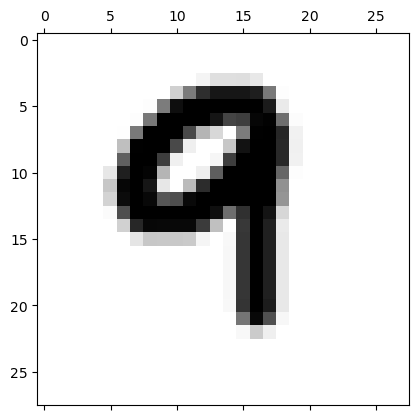

In [17]:
from PIL import Image

image = Image.open('Digit.png')
img = image.convert('L')    # converts it to greyscale
img = img.resize((28,28))
img = np.asarray(img)

plt.matshow(img, cmap = 'gray_r')
plt.show()

In [18]:
imgtensor = transform(np.array(img))
with torch.inference_mode():
    
    output = model(imgtensor)
    guess=(torch.max(torch.exp(output), 1)[1])[0]
    perc=torch.max(torch.exp(output)/torch.exp(output).sum())*100
    print(f'This is {guess}, and I am {perc:.1f}% confident about this')

This is 9, and I am 57.2% confident about this


Overall out guess were good, but for image recognition, we should be using a different type of Neural Network called Convolutional Neural Network (CNN), which we will look at next time.

### Dealing with overfit

Neural networks are notorious at overfitting since they add a lot of complexity. This is even more prominent for small data sets. There are a few ways to combat overfitting:

1. For non-image data normalization is helpful
2. Data augmentation: adding small rotation, shifts and noise to images
3. Adding regularizatrion. Recall that weight decay in SGD is L2-regularization
4. Dropout: we can randomly drop a few neurons in each training iteration to add a bit of weight indpendence.
5. Early stopping. stop training when validation accurace no longer improves.
6. Pooling: dimension reduction on images.

Let's take a smaller subset of digits and increase amount of epochs. We will run first model with the same settings as before, and for the second model, we will add few extra things to combat overfit

In [24]:
trainset_list= list(trainset)
testset_list= list(testset)
trainset_list=trainset_list[:20]
testset_list=testset_list[:2000]
trainloader = torch.utils.data.DataLoader(trainset_list, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset_list, batch_size=100, shuffle=True)

In [25]:
model1 = DigitMLP()
n_epochs=300
lr=0.01

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=lr, momentum =0.9)

In [26]:
train_loss = []
test_loss = []
train_acc=[]
test_acc=[]

In [27]:
for epoch in range(n_epochs):
    model1.train()
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        images = images.reshape(-1, 28*28)
        output = model1(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()

    
    model1.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model1, testloader)            
        test_acc.append(acc)
        test_loss.append(loss)

        acc, loss = get_acc_loss(model1, trainloader)            
        train_acc.append(acc)
        train_loss.append(loss)
        
    if epoch%10==9:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss={loss.item():.3}')


Epoch 10/300, Loss=1.92
Epoch 20/300, Loss=0.534
Epoch 30/300, Loss=0.041
Epoch 40/300, Loss=0.0137
Epoch 50/300, Loss=0.00722
Epoch 60/300, Loss=0.0032
Epoch 70/300, Loss=0.00405
Epoch 80/300, Loss=0.00435
Epoch 90/300, Loss=0.00258
Epoch 100/300, Loss=0.0028
Epoch 110/300, Loss=0.00304
Epoch 120/300, Loss=0.00262
Epoch 130/300, Loss=0.00229
Epoch 140/300, Loss=0.00175
Epoch 150/300, Loss=0.00137
Epoch 160/300, Loss=0.00193
Epoch 170/300, Loss=0.00145
Epoch 180/300, Loss=0.00119
Epoch 190/300, Loss=0.00127
Epoch 200/300, Loss=0.00108
Epoch 210/300, Loss=0.00127
Epoch 220/300, Loss=0.000995
Epoch 230/300, Loss=0.000725
Epoch 240/300, Loss=0.000779
Epoch 250/300, Loss=0.000695
Epoch 260/300, Loss=0.000902
Epoch 270/300, Loss=0.000843
Epoch 280/300, Loss=0.000782
Epoch 290/300, Loss=0.000833
Epoch 300/300, Loss=0.000631


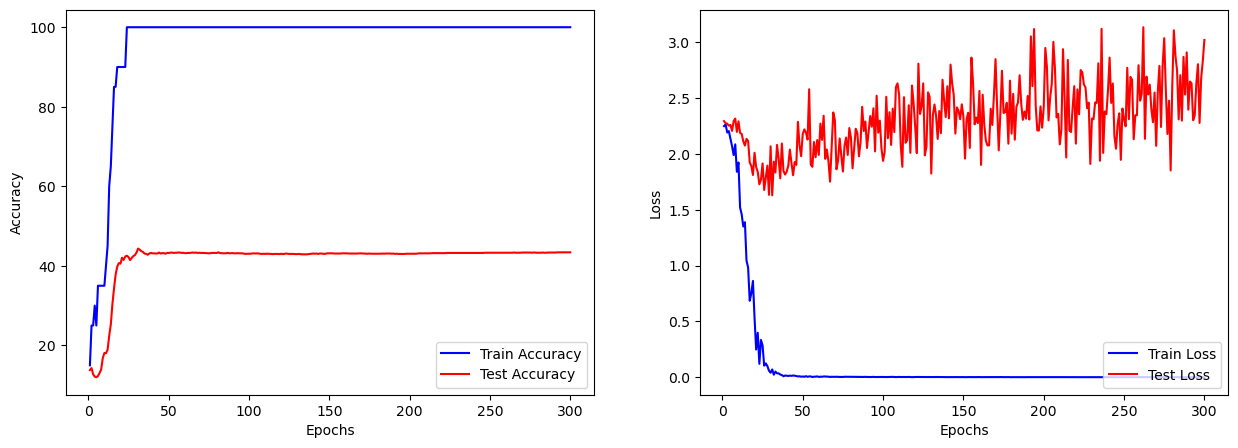

In [28]:
fig, ax= plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,n_epochs+1, 1), train_acc, color='blue')
ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc, color='red')
ax[0].legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(np.arange(1,n_epochs+1, 1), train_loss, color='blue')
ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss, color='red')
ax[1].legend(['Train Loss', 'Test Loss'], loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

As you can see we our model does perfectly on train set, but badly on test set. We are overfitting. Let add few things to our model. First thing we will add a bit of rotation to our images. Normally you can add those to your initial transform, but this time I will add it separately. Here is an example:

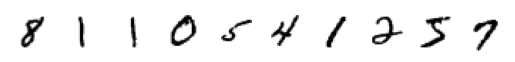

In [31]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 10
for index in range(0, num_of_images):
    plt.subplot(1, 10, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

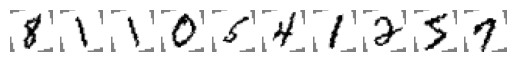

In [32]:
images=transforms.RandomRotation(25)(images)
figure = plt.figure()
num_of_images = 10
for index in range(0, num_of_images):
    plt.subplot(1, 10, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Next, we will use L2-Normalization by setting weight decay to 0.01. Finally, we will add a dropout layers to remove certain neurons. Note that dropout layer is not being used during testing. Your model will know if you are testing or training when you use `model.eval()` and `model.train()`.

In [39]:
input_size = 784     # 28*28
hidden_sizes = [128, 64] #two hidden layers
output_size = 10


class DigitMLP2(nn.Module):
    
    def __init__(self):
        super(DigitMLP2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(input_size,hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_sizes[1], output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [40]:
model2 = DigitMLP2()
n_epochs=300
lr=0.01

In [41]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=lr, momentum =0.9, weight_decay=0.01)

In [42]:
train_loss = []
test_loss = []
train_acc=[]
test_acc=[]

In [43]:
for epoch in range(n_epochs):
    model2.train()
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        images=transforms.RandomRotation(25)(images)
        images = images.reshape(-1, 28*28)
        output = model2(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()

        #if (idx+1)%5==0:
            #print(f'Epoch {epoch+1}/{n_epochs}, step {idx+1}/{n}, Loss={loss.item():.3}')

    model2.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model2, testloader)            
        test_acc.append(acc)
        test_loss.append(loss)

        acc, loss = get_acc_loss(model2, trainloader)            
        train_acc.append(acc)
        train_loss.append(loss)

    if epoch%10==9:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss={loss.item():.3}')

Epoch 10/300, Loss=2.0
Epoch 20/300, Loss=1.65
Epoch 30/300, Loss=1.22
Epoch 40/300, Loss=0.628
Epoch 50/300, Loss=0.348
Epoch 60/300, Loss=0.386
Epoch 70/300, Loss=0.289
Epoch 80/300, Loss=0.224
Epoch 90/300, Loss=0.152
Epoch 100/300, Loss=0.123
Epoch 110/300, Loss=0.141
Epoch 120/300, Loss=0.137
Epoch 130/300, Loss=0.0821
Epoch 140/300, Loss=0.0495
Epoch 150/300, Loss=0.0701
Epoch 160/300, Loss=0.0522
Epoch 170/300, Loss=0.0723
Epoch 180/300, Loss=0.0132
Epoch 190/300, Loss=0.0366
Epoch 200/300, Loss=0.0345
Epoch 210/300, Loss=0.0247
Epoch 220/300, Loss=0.00973
Epoch 230/300, Loss=0.0129
Epoch 240/300, Loss=0.00816
Epoch 250/300, Loss=0.000855
Epoch 260/300, Loss=0.00331
Epoch 270/300, Loss=0.0292
Epoch 280/300, Loss=0.00641
Epoch 290/300, Loss=0.00847
Epoch 300/300, Loss=0.0279


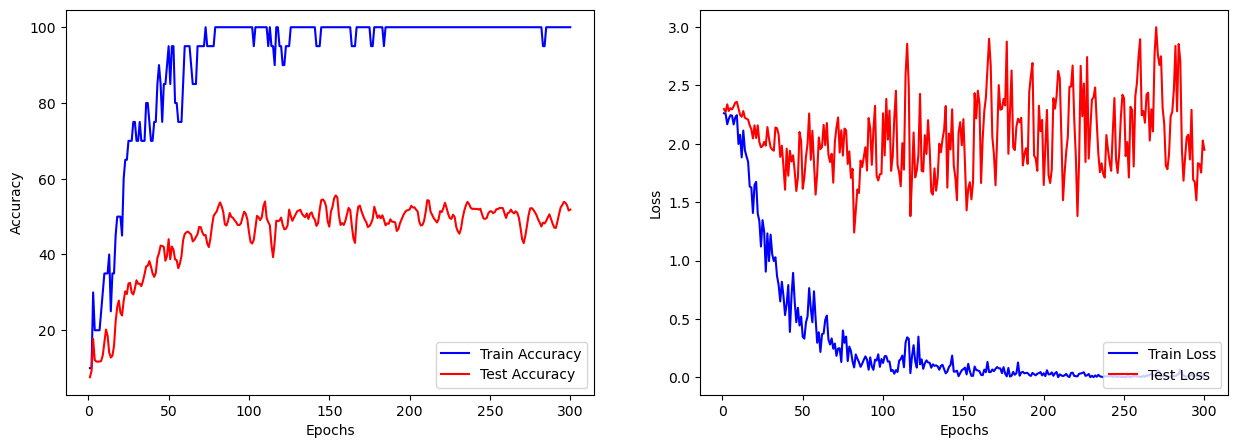

In [44]:
fig, ax= plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,n_epochs+1, 1), train_acc, color='blue')
ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc, color='red')
ax[0].legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(np.arange(1,n_epochs+1, 1), train_loss, color='blue')
ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss, color='red')
ax[1].legend(['Train Loss', 'Test Loss'], loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()